In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from seaborn import heatmap
from sklearn.decomposition import PCA # Principal Component Analysis
from statsmodels.tsa.vector_ar.var_model import VAR # Vector Auto Regressive model
from statsmodels.tsa.stattools import (
    adfuller, 
    kpss, 
    grangercausalitytests
    ) # Homoscedasticity & Causality tests 



pd.set_option('display.max_columns', 40)
plt.rcParams.update({'axes.grid': True, 'grid.alpha': .33})


df: pd.DataFrame = pd.read_csv("Life Expectancy Data.csv")


# Format DataFrame for further analysis
stripped_columns = []

for col_num, col_name in enumerate(df.columns):
    stripped_columns.append(col_name.strip(' '))
    
df.columns = stripped_columns

# Failsafe DataFrame in case we duck up something
df = df.sort_values(by=['Country', 'Year'])
df = df.reset_index(drop=True)


# Dictionary with countries as keys and corresponding DataFrame slices as values
df_per_country = {country: df for country, df in df.groupby('Country')}

**<h4>**Handling outliers**<h4>**

In [100]:
# Replace values beyond IQR with median
for country, country_df in df_per_country.items():
    for column in country_df.columns[4:]:

        descriptive_stats = country_df[column].describe()


        median = descriptive_stats['50%']
        Q1 = descriptive_stats['25%']
        Q3 = descriptive_stats['75%']
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        upper_condition = (country_df[column] > upper_bound)
        lower_condition = (country_df[column] < lower_bound)

        combined_boolean_indexing = (upper_condition | lower_condition)
        
        country_df.loc[combined_boolean_indexing, column] = median

        


C:\Users\user\AppData\Local\Temp\ipykernel_17644\1032146720.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '111.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  country_df.loc[combined_boolean_indexing, column] = median
C:\Users\user\AppData\Local\Temp\ipykernel_17644\1032146720.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  country_df.loc[combined_boolean_indexing, column] = median
C:\Users\user\AppData\Local\Temp\ipykernel_17644\1032146720.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '109.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  country_

In [101]:
# Restoring DataFrame to its original shape
df = pd.concat(df_per_country.values())

**<h2>**Handling missing data**</h2>**
**<h4>**For every column that contains NULL values we look for the indexes of missing values in order to understand the nature of the absence**<h4>**

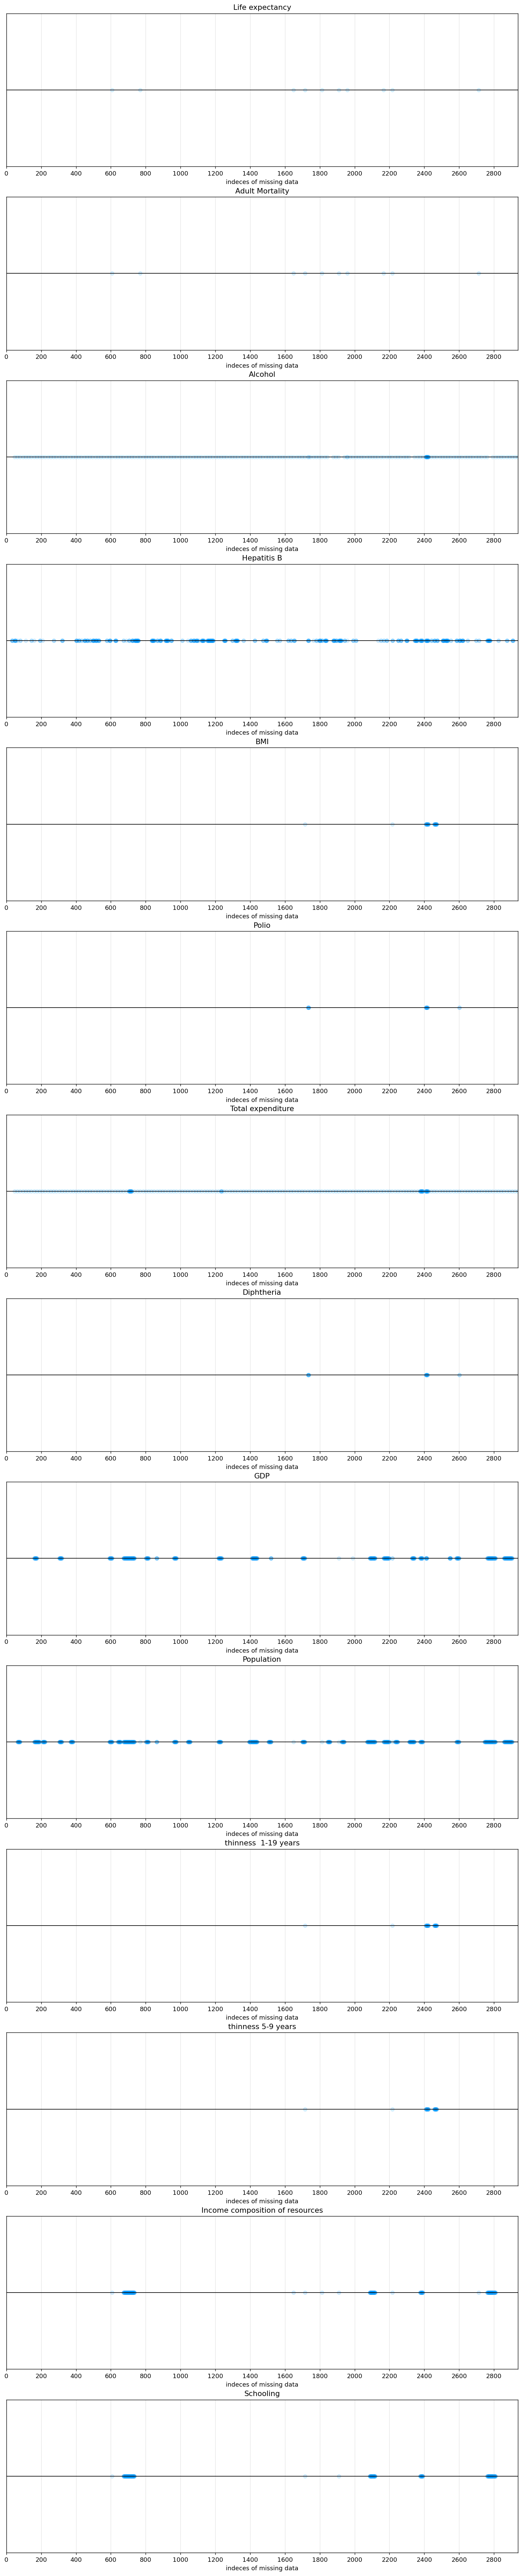

In [102]:
columns_with_null_values = df.columns[(df.isnull().sum()>0).values]
column_and_indeces = {}

for column in columns_with_null_values:
    column_and_indeces[column] = df[df[column].isnull()==True].index

fig, axes = plt.subplots(len(column_and_indeces), figsize = (15, 75), dpi = 130)
xmin = 0
xmax = len(df)


for index, (key, values) in enumerate(column_and_indeces.items()):
    axes[index].hlines(y=0, xmin=xmin, xmax=xmax, color='black', linewidth=1)

    axes[index].scatter(values, [0] * len(values), color=(0,0.6,1), alpha=0.15)

    axes[index].set_yticks([])
    axes[index].set_xticks(np.arange(xmin, xmax, 200))

    axes[index].set_xlim(0, 2938)
    axes[index].set_ylim(-1, 1)

    axes[index].set_title(key)
    axes[index].set_xlabel('indeces of missing data')

**<h4>**We can see that for certain columns the reason behind missing data is not completely random (Alcohol, BMI, Diphteria and so on.)**</h4>**

**<h5>**This is not good, because we cannot really drop rows with null values as we're going to lose insane amount of data, and standard techniques such as filling Null values with median/mean of corresponding column will not be quite statistically accurate**</h5>**

**<h5>**Thus, I tried impementing another way of handling missing data**</h5>**
<br><br>
**<h3>**That's an experimental method to fill in NA values so I don't really count on its theorethical foundation**<h3>**

In [103]:
from numpy.linalg import norm
from numpy import dot 



# Define cosine similarity function
def cosine_similarity(a: tuple | list,b: tuple | list) -> np.float64:

    return dot(a,b) / (norm(a) * norm(b))


# Leaving only rows with NULL values in DataFrame 
non_null_indexes = df.dropna().index
null_indexes = []

for index in df.index:
    if index not in non_null_indexes:
        null_indexes.append(index)


# DataFrame without null values
df_wo_null_values = df.copy()
df_wo_null_values = df_wo_null_values.dropna()
df_wo_null_values = df_wo_null_values.reset_index(drop=True)

# DataFrame with null values
df_with_null_values = df.copy()
df_with_null_values = df_with_null_values.iloc[null_indexes, :]
df_with_null_values = df_with_null_values.reset_index(drop=True)

for row_num, row in df_with_null_values.iterrows():

    columns_with_null_values = row[row.isnull()].index

    feature_vector = tuple(row.fillna(0).values)[3:]

    similarities = []

    for row_num_2, row_2 in df_wo_null_values.iterrows():

        feature_vector_2 = row_2.copy()
        feature_vector_2[columns_with_null_values] = 0
        feature_vector_2 = tuple(feature_vector_2.values)[3:]

        similarity = cosine_similarity(feature_vector, feature_vector_2)

        row_similarity = {row_num_2: similarity}
        similarities.append(row_similarity)
    

    
    series = pd.Series(similarities).apply(lambda x: list(x.values())[0])
    most_similar_rows = series.sort_values(ascending=False)[:100]
    most_similar_rows_indexes = most_similar_rows.index

    median_values = df_wo_null_values.loc[most_similar_rows_indexes, columns_with_null_values].median()
    mad = (df_wo_null_values.loc[most_similar_rows_indexes, columns_with_null_values] - df_wo_null_values.loc[most_similar_rows_indexes, columns_with_null_values].mean()).abs().mean() 
    normally_distributed_value = np.random.normal(loc=0, scale=1, size=1)[0]

    values_to_fill = median_values + mad * normally_distributed_value
    df_with_null_values.loc[row_num, columns_with_null_values] = values_to_fill

In [105]:
# Save result as it takes way too much to run the algorithm above
df = pd.concat([df_wo_null_values, df_with_null_values]).reset_index(drop=True).sort_values(by=['Country', 'Year'])
df.to_csv('restored_df.csv')

In [106]:
cleaned_df = pd.read_csv('restored_df.csv')

**<h3>**Now as we have cleaned DataFrame without significat outliers, we can break this task into 2:**</h3>**

**<h4>**1) Regression Analysis for each year<br>2) Time Series Analysis for each country**</h4>**


**<h5>**NOTE: We can justify looking at the problem from regression point of view analysis the bare minimum condition of having atleast 5-6 training example per feature is satisfied**</h5>**


In [107]:
regression_df = cleaned_df.copy()
regression_df = regression_df.sort_values(by='Year')
regression_df = regression_df.reset_index(drop=True)

regression_df['Status'] = regression_df['Status'].replace({
    "Developed": 1,
    "Developing": 0,
})


**<h3>**Let us investigate the feature space on correlations in order to have our model build on a correct dataset that will not result in statistically insignificant results**</h3>**

<Axes: >

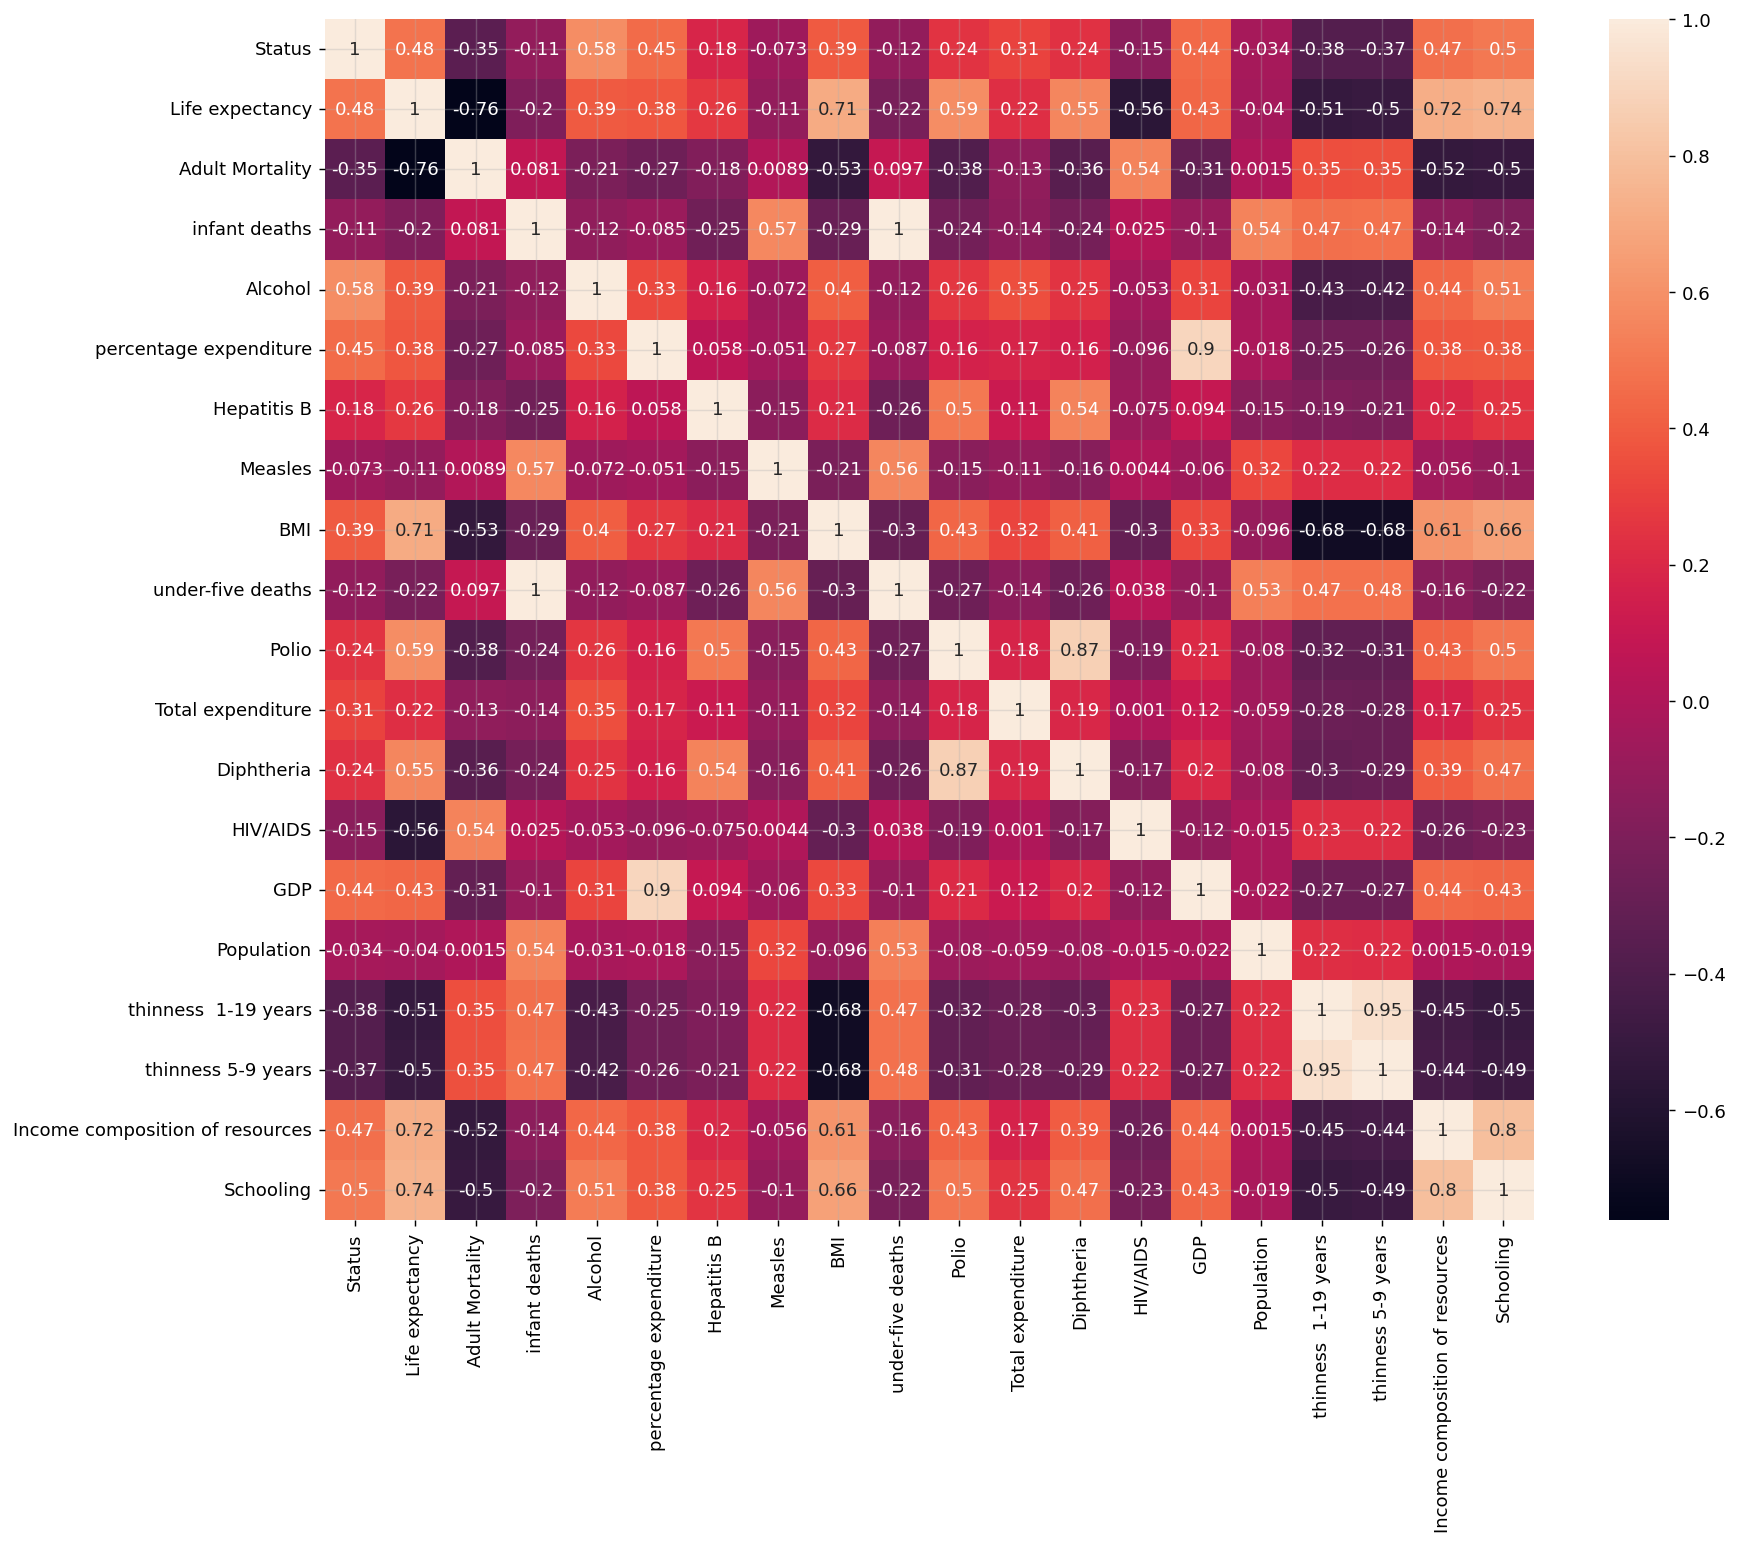

In [108]:
fig, ax = plt.subplots(figsize = (15,12), dpi=130)


heatmap(regression_df[regression_df.columns[3:]].corr(), annot=True, ax=ax)

**<h3>**Principal Component Analysis**</h3>**

In [109]:
feature_columns = regression_df.drop('Life expectancy', axis=1).columns[3:]

for column in feature_columns:
    x = regression_df[column]
    regression_df[column] = (x-x.mean())/x.std(ddof=1)

regression_df_features = regression_df[feature_columns]



pca = PCA(n_components = len(regression_df_features.columns))
pca.fit(regression_df_features)
sliced_regression_df_wo_null = pca.transform(regression_df_features)



importance = np.abs(pca.components_) * pca.explained_variance_ratio_.reshape(-1, 1)
feature_importance = importance.sum(axis=0)

for col_name, importance in zip(regression_df.columns[2:], feature_importance):
    print(col_name, '-', importance)

Year - 0.20987275954405646
Status - 0.20709935669539864
Life expectancy - 0.1732529308246275
Adult Mortality - 0.2041551115835821
infant deaths - 0.20098179596193266
Alcohol - 0.19082741524338204
percentage expenditure - 0.1854257902095089
Hepatitis B - 0.1812171545737159
Measles - 0.17360456821066622
BMI - 0.17651766385812637
under-five deaths - 0.16890906819185203
Polio - 0.17644829342783896
Total expenditure - 0.19219815694814668
Diphtheria - 0.20450374437319377
HIV/AIDS - 0.17520485075023456
GDP - 0.20327241770610915
Population - 0.20304338886540532
thinness  1-19 years - 0.19802165569764177
thinness 5-9 years - 0.18657811601233917


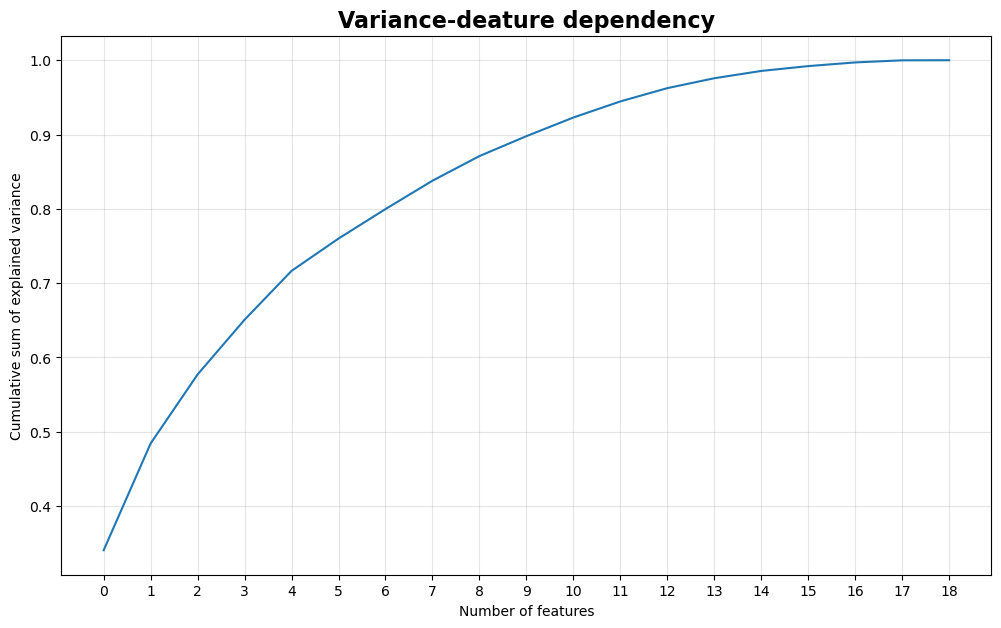

In [110]:
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12,7), dpi=100)
plt.plot(cumsum_variance)
plt.xticks(np.arange(len(regression_df_features.columns)))
plt.ylabel('Cumulative sum of explained variance')
plt.xlabel('Number of features')
plt.title('Variance-deature dependency', fontdict={'fontsize': 16, 'weight': 'bold'})
plt.show()

**<h3>**With the help of correlation matrix and PCA we can say that there are a couple of features that highly correlated with other features, which is not good from statistical point of view, so we're going to remove certain features from the dataset**</h3>**

**<h3>**We also saw that all the features contribte to the target variable relatively the same**</h3>**



In [111]:
regression_df = cleaned_df.copy()
regression_df = regression_df.drop(['Country', 'under-five deaths', 'percentage expenditure', 'thinness 5-9 years'], axis=1)
num_of_observations_per_year = regression_df.groupby('Year')['Life expectancy'].count()
num_of_observations_per_year

Year
2000    183
2001    183
2002    183
2003    183
2004    183
2005    183
2006    183
2007    183
2008    183
2009    183
2010    183
2011    183
2012    183
2013    193
2014    183
2015    183
Name: Life expectancy, dtype: int64

**<h3>**Since we've done proper cleaning and outliers handling, we have 183 observations per year (except 2013)**<h3>**

In [112]:
# Group DataFrames by years
regression_dfs_by_year = {year: df for year, df in regression_df.groupby('Year')}

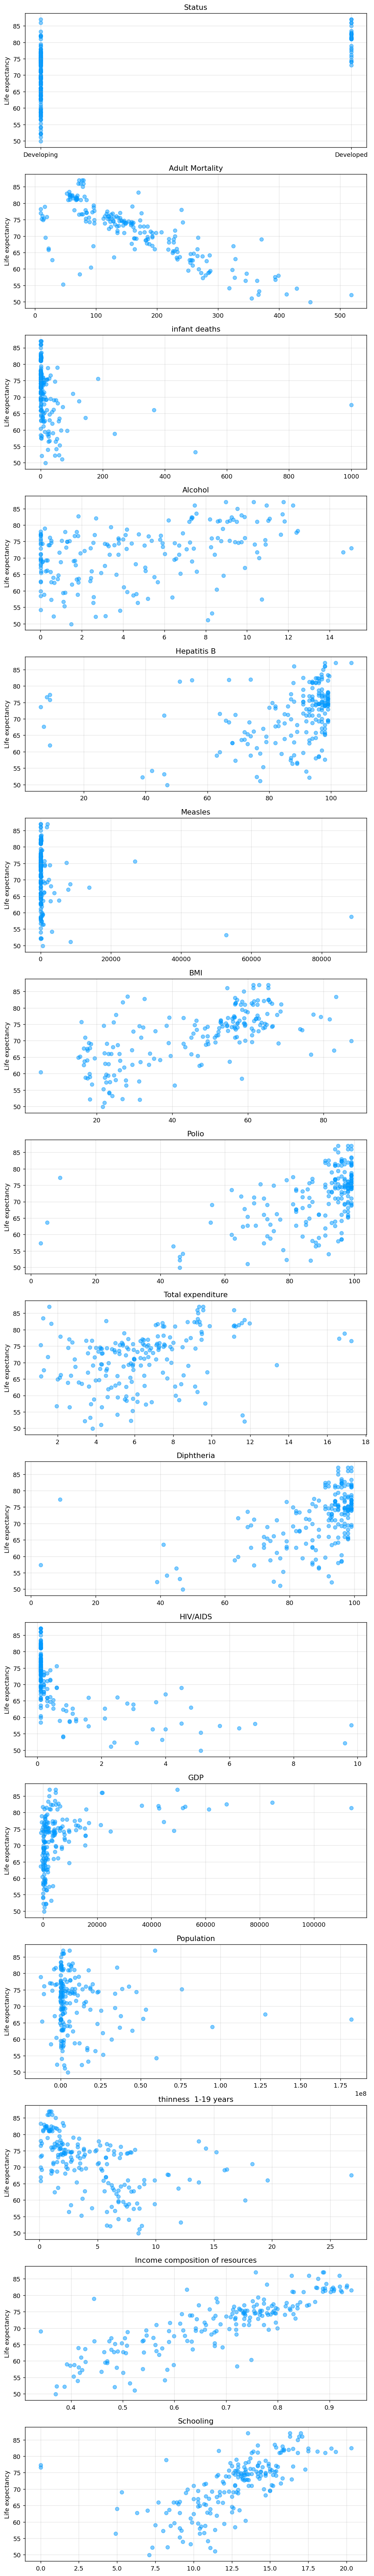

In [113]:
regression_features = regression_df.columns.drop(['Unnamed: 0','Year','Life expectancy'])
fig, axes = plt.subplots(len(regression_features), figsize=(10, 75), dpi=130)

for col_num, col_name in enumerate(regression_features):

    axes[col_num].scatter(regression_dfs_by_year[2013][col_name], regression_dfs_by_year[2013]['Life expectancy'], alpha=0.5, color=(0,0.6,1))
    axes[col_num].set_title(col_name)
    axes[col_num].set_label(col_name)
    axes[col_num].set_ylabel('Life expectancy')



**<h3>**Importing statsmodels' Linear Regression for look at the dependencies:**</h3>**


In [114]:
from statsmodels.api import OLS

linreg_results = {}

for year, df in regression_dfs_by_year.items():
    feature_matrix = df[df.columns[4:]]
    target = df['Life expectancy']

    linreg_statsmodels = OLS(target, feature_matrix).fit()
    linreg_results[year] = linreg_statsmodels



In [115]:
for year in linreg_results.keys():
    print(f'for {year} R^2 is:\n{linreg_results[year].rsquared}')
    print('-'*18)
    print('\n')

for 2000 R^2 is:
0.9908488497768886
------------------


for 2001 R^2 is:
0.9913627630818377
------------------


for 2002 R^2 is:
0.9910586498363371
------------------


for 2003 R^2 is:
0.9906001665678928
------------------


for 2004 R^2 is:
0.9898593700615224
------------------


for 2005 R^2 is:
0.9909608513594623
------------------


for 2006 R^2 is:
0.9937304116206237
------------------


for 2007 R^2 is:
0.9927919234357071
------------------


for 2008 R^2 is:
0.9938398525924298
------------------


for 2009 R^2 is:
0.993106784690325
------------------


for 2010 R^2 is:
0.993234238801798
------------------


for 2011 R^2 is:
0.9936003619434346
------------------


for 2012 R^2 is:
0.9936130001340908
------------------


for 2013 R^2 is:
0.9947578971888167
------------------


for 2014 R^2 is:
0.9946914641493948
------------------


for 2015 R^2 is:
0.9960318772257714
------------------




**<h4>**In OLS summary we have coefficients for every feature and corresponding p value which basically inditcates the "probability" of these coefficinets being not statistically significant, so for each year we look at the feature whose coefficients are significant enough (p value < 0.05)**<h4>**

In [116]:
for year in linreg_results.keys():
    print(f"{year}'s relevant feature (corresponding p values) are: \n\n{linreg_results[year].pvalues[linreg_results[year].pvalues<0.05]}")
    print('-'*37)
    print('\n\n\n')

2000's relevant feature (corresponding p values) are: 

Adult Mortality                    2.812136e-02
Hepatitis B                        3.048548e-07
BMI                                5.611341e-06
Polio                              2.806576e-03
HIV/AIDS                           2.540599e-09
thinness  1-19 years               8.579747e-06
Income composition of resources    2.562436e-03
Schooling                          8.735044e-03
dtype: float64
-------------------------------------




2001's relevant feature (corresponding p values) are: 

Hepatitis B                        9.673778e-07
Measles                            2.198256e-02
BMI                                1.559471e-03
Total expenditure                  1.455173e-03
HIV/AIDS                           1.292152e-09
thinness  1-19 years               9.130089e-06
Income composition of resources    1.163679e-02
Schooling                          2.513164e-03
dtype: float64
-------------------------------------




2002's

**<h2>**Multivariate Time Series Analysis**</h2>**

<br><br>
**<h4>**As 'Status' column is not informationally significant to our time serieses because it is a basically a constant we can drop this column**<h4>**

In [117]:
tsa_df = cleaned_df.copy()
tsa_df = tsa_df.sort_values(by=['Country', 'Year'])
tsa_df = tsa_df.drop('Status', axis=1)
tsa_df = tsa_df.drop(['under-five deaths', 'percentage expenditure', 'thinness 5-9 years'], axis=1)

num_of_observations_per_country = tsa_df.groupby('Country')['Life expectancy'].count()
relevant_countries = num_of_observations_per_country[num_of_observations_per_country.sort_values(ascending=True)>10]


In [118]:
tsa_dfs_by_country = {country: df for country, df in tsa_df.groupby('Country')}
feature_columns = tsa_df.columns.drop(['Unnamed: 0', 'Country', 'Year', 'Life expectancy'])
target_column = 'Life expectancy'


In [119]:
Afghanistan = tsa_dfs_by_country['Afghanistan'][feature_columns]
Afghanistan

,Adult Mortality,infant deaths,Alcohol,Hepatitis B,Measles,BMI,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,Income composition of resources,Schooling
0,321.0,88.0,0.01,62.0,1794.0,12.2,24.0,8.20,24.0,0.1,114.560000,293756.0,18.5,0.338,5.5
1,316.0,88.0,0.01,63.0,1794.0,12.6,35.0,7.80,33.0,0.1,117.496980,2966463.0,18.5,0.340,5.9
2,284.0,88.0,0.01,64.0,2486.0,13.0,36.0,7.76,36.0,0.1,187.845950,21979923.0,19.9,0.341,6.2
3,295.0,87.0,0.01,65.0,798.0,13.4,41.0,8.82,41.0,0.1,198.728544,2364851.0,19.7,0.373,6.5
4,293.0,87.0,0.02,67.0,466.0,13.8,5.0,8.79,5.0,0.1,219.141353,24118979.0,19.5,0.381,6.8
5,291.0,85.0,0.02,66.0,1296.0,14.2,58.0,8.70,58.0,0.1,25.294130,257798.0,19.3,0.396,7.9
6,295.0,84.0,0.03,64.0,1990.0,14.7,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,0.405,8.1
7,295.0,82.0,0.02,63.0,1141.0,15.2,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,0.415,8.4
8,287.0,80.0,0.03,64.0,1599.0,15.7,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,0.433,8.7
9,281.0,77.0,0.01,63.0,2861.0,16.2,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,0.434,8.9


In [140]:
def check_for_stationarity(time_series: pd.Series) -> dict:

    stationarity = {}
    threshold = 0.05

    if time_series.max() != time_series.min():

        # Check via Dickey Fuller's aka unit root test (Variance stationarity)
        adfuller_test = adfuller(time_series)
        adfuller_p_value = adfuller_test[1]

        if adfuller_p_value >= 0.05:
            stationarity['Dickey_Fuller'] = "Not stationary"
        else:
            stationarity['Dickey_Fuller'] = "Stationary"


        # Check via KPSS aka trend test (Mean stationarity)
        kpss_test = kpss(time_series)
        kpss_p_value = kpss_test[1]

        if kpss_p_value <= 0.05:
            stationarity['KPSS'] = "Not stationary"
        else:
            stationarity['KPSS'] = "Stationary"

    else:
        stationarity['Dickey_Fuller'], stationarity['KPSS'] = "Stationary", "Stationary"

    return stationarity


for column in Afghanistan.columns:
    print(f"{column}:\n")
    print(f"Dickey-Fuller is:\n{check_for_stationarity(Afghanistan[column])['Dickey_Fuller']}\n\nKPSS is:\n{check_for_stationarity(Afghanistan[column])['KPSS']} \n{"-"*25}\n")





Adult Mortality:

Dickey-Fuller is:
Not stationary

KPSS is:
Not stationary 
-------------------------

infant deaths:

Dickey-Fuller is:
Not stationary

KPSS is:
Not stationary 
-------------------------

Alcohol:

Dickey-Fuller is:
Not stationary

KPSS is:
Stationary 
-------------------------

Hepatitis B:

Dickey-Fuller is:
Stationary

KPSS is:
Stationary 
-------------------------

Measles:

Dickey-Fuller is:
Not stationary

KPSS is:
Stationary 
-------------------------

BMI:

Dickey-Fuller is:
Not stationary

KPSS is:
Not stationary 
-------------------------

Polio:

Dickey-Fuller is:
Not stationary

KPSS is:
Stationary 
-------------------------

Total expenditure:

Dickey-Fuller is:
Stationary

KPSS is:
Stationary 
-------------------------

Diphtheria:

Dickey-Fuller is:
Not stationary

KPSS is:
Not stationary 
-------------------------

HIV/AIDS:

Dickey-Fuller is:
Stationary

KPSS is:
Stationary 
-------------------------

GDP:

Dickey-Fuller is:
Not stationary

KPSS is:
N

C:\Users\user\AppData\Local\Temp\ipykernel_17644\134796137.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(time_series)
C:\Users\user\AppData\Local\Temp\ipykernel_17644\134796137.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(time_series)
C:\Users\user\AppData\Local\Temp\ipykernel_17644\134796137.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(time_series)
C:\Users\user\AppData\Local\Temp\ipykernel_17644\134796137.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater 

In [148]:
(Afghanistan['BMI'] - Afghanistan['BMI'].shift(1)).dropna()

1     0.4
2     0.4
3     0.4
4     0.4
5     0.4
6     0.5
7     0.5
8     0.5
9     0.5
10    0.5
11    0.5
12    0.4
13    0.5
14    0.5
15    0.5
Name: BMI, dtype: float64

In [ ]:
from scipy.stats import yeojohnson # extension of Box-Cox transformation into all real values numbers


def check_for_adfuller_stationarity(time_series: pd.Series) -> dict:

    threshold = 0.05

    if time_series.max() != time_series.min():

        # Check via Dickey Fuller's aka unit root test (Variance stationarity)
        adfuller_test = adfuller(time_series)
        adfuller_p_value = adfuller_test[1]

        if adfuller_p_value >= 0.05:
            return "Not stationary"
        else:
            return "Stationary"
        
    else:
        return "Stationary"
    

def check_for_kpss_stationarity(time_series: pd.Series) -> dict:

    threshold = 0.05

    if time_series.max() != time_series.min():

        # Check via KPSS aka trend test (Mean stationarity)
        kpss_test = kpss(time_series)
        kpss_p_value = kpss_test[1]

        if kpss_p_value <= 0.05:
            return "Not stationary"
        else:
            return "Stationary"
        
    else:
        return "Stationary"



def make_stationary(time_series: pd.Series) -> pd.Series | str:
    """
    Function to make non-stationary data stationary
    """

    adfuller_stationary = check_for_adfuller_stationarity(time_series)
    kpss_stationary = check_for_kpss_stationarity(time_series)


    # Yeo Johnson transfrom if data is not variance stationary
    if adfuller_stationary == "Not stationary":
        time_series = yeojohnson(time_series)[0]

    # Recheck variance stationarity
    adfuller_stationary = check_for_adfuller_stationarity(time_series)
    if adfuller_stationary == "Not stationary":
        return "Cannot be made stationary"





    # First differencing if TS is not trend stationary
    if kpss_stationary == "Not stationary":
        time_series = (time_series - time_series.shift(1)).dropna()

    kpss_stationary = check_for_kpss_stationarity(time_series)

    # Second differencing if TS is not trend stationary
    if kpss_stationary == "Not stationary":
        time_series = (time_series - time_series.shift(1)).dropna()

    kpss_stationary = check_for_kpss_stationarity(time_series)

    if kpss_stationary == "Not stationary":
        return "Cannot be made stationary"



    